# Problem Statement
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual value and flip them at a higher price. For the same purpose, the company has collected a data set from house sales in Australia. The company is looking at prospective properties to buy to enter the market.
The company wants to know:
- Which variables are significant in predicting the price of a house
- How well those variables describe the price of a house

We are required to model the price of houses with the available independent variables. It will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high rewards. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

In [440]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [441]:
# Importing all the required libraries
import numpy as np
import pandas as pd

# Importing the visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale the data
from sklearn.preprocessing import MinMaxScaler

# To build the model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

## Generic Functions

In [442]:
def get_nulls_report(df,apply_style="Y"):
    if apply_style=="Y":
        cm = sns.light_palette("orange", as_cmap=True)
        return pd.DataFrame([df.isnull().sum(),round(100*(df.isnull().sum()/len(df.index)), 2)]).T.rename(columns={0:'Total Nulls',1:'Nulls Percentage'}).\
sort_values(by='Nulls Percentage',ascending=False).style.background_gradient(cmap=cm)
    else:
        return pd.DataFrame([df.isnull().sum(),round(100*(df.isnull().sum()/len(df.index)), 2)]).T.rename(columns={0:'Total Nulls',1:'Nulls Percentage'}).\
sort_values(by='Nulls Percentage',ascending=False)

In [443]:
def get_variables_type(df,type_of_var):
    if type_of_var=="CATERGORICAL":
        return list(df.select_dtypes(exclude=[np.number]).columns)
    else:
        return list(df.select_dtypes(include=[np.number]).columns)   

In [444]:
def get_column_frequency(ds):
    return pd.DataFrame(ds.value_counts(dropna=False))

In [445]:
def draw_univariate_plot(df):
 sns.set(style="darkgrid")   
 sns.set_palette(sns.color_palette("hls",20))
 
 for cols in df.columns:
        fig, ax=plt.subplots(nrows =1,ncols=2,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[cols],ax=ax[0])
        ax[1].set_title("Box Plot")
        sns.boxplot(data =df, x=cols,ax=ax[1],orient='v')
        plt.xticks(rotation='vertical',fontsize=12)
        plt.show()

## Reading data from the provided data 

In [446]:
# Read the CSV and import data  into the dataframe names "surprice_housing_df"
surprise_housing_df = pd.read_csv("train.csv")

In [447]:
# Read the data from the dataframe 
surprise_housing_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [448]:
# Data analysis by understanding the Meta data 
surprise_housing_df.shape

(1460, 81)

In [449]:
# checking the name of the columns and the datatypes
surprise_housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [450]:
surprise_housing_df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

           ...         WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count      ...        1460.000000  1460.000000    1460.000000  1460.000000   
mean       ...          94.244521    46.660274      21.954110     3.409589   
std        ...         125.338794    66.256028      61.119149    29.317331   
min        ...           0.000000     0.000000       0.000000     0.000000   
25%        ...           0.000000     0.000000       0.000000     0.000000   
50%        ...           0.000000    25.000000       0.000000     0.000000   
75%        ...         168.000000    68.000000       0.000000     0.000000   
max        ...         857.000000   547.000000     552.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean     15.060959     2.758904     43.489041     6.321918  2007.815753   
std      55.757415    40.177307    496.123024     2.703626     1.328095   
min       0.000000     0.000000      0.000000     1.000000  2006.000000   
25%       0.000000     0.000000      0.000000     5.000000  2007.000000   
50%       0.000000     0.000000      0.000000     6.000000  2008.000000   
75%       0.000000     0.000000      0.000000     8.000000  2009.000000   
max     480.000000   738.000000  15500.000000    12.000000  2010.000000   

           SalePrice  
count    1460.000000  
mean   180921.195890  
std     79442.502883  
min     34900.000000  
25%    129975.000000  
50%    163000.000000  
75%    214000.000000  
max    755000.000000  

[8 rows x 38 columns]

In [451]:
# Checking for the duplicate records in the Id Column 
surprise_housing_df['Id'].nunique()

1460

In [452]:
surprise_housing_df.isnull().values.any()

True

In [453]:
# Fetch the null reports of the variables 
get_nulls_report(surprise_housing_df)

#### Before Imputing the value breifly go through the distinct values of the columns where we need to impute

In [454]:
print("PoolQC",surprise_housing_df['PoolQC'].unique())
print("MiscFeature",surprise_housing_df['MiscFeature'].unique())
print("Alley",surprise_housing_df['Alley'].unique())
print("Fence",surprise_housing_df['Fence'].unique())
print("FireplaceQu",surprise_housing_df['FireplaceQu'].unique())
print("GarageCond",surprise_housing_df['GarageCond'].unique())
print("GarageType",surprise_housing_df['GarageType'].unique())
print("GarageFinish",surprise_housing_df['GarageFinish'].unique())
print("GarageQual",surprise_housing_df['GarageQual'].unique())
print("BsmtExposure",surprise_housing_df['BsmtExposure'].unique())
print("BsmtFinType2",surprise_housing_df['BsmtFinType2'].unique())
print("BsmtFinType1",surprise_housing_df['BsmtFinType1'].unique())
print("BsmtCond",surprise_housing_df['BsmtCond'].unique())
print("BsmtQual",surprise_housing_df['BsmtQual'].unique())
print("MasVnrType",surprise_housing_df['MasVnrType'].unique())
print("Electrical",surprise_housing_df['Electrical'].unique())

PoolQC [nan 'Ex' 'Fa' 'Gd']
MiscFeature [nan 'Shed' 'Gar2' 'Othr' 'TenC']
Alley [nan 'Grvl' 'Pave']
Fence [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
FireplaceQu [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageCond ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
GarageType ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
GarageFinish ['RFn' 'Unf' 'Fin' nan]
GarageQual ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' nan]
BsmtFinType2 ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
BsmtCond ['TA' 'Gd' nan 'Fa' 'Po']
BsmtQual ['Gd' 'TA' 'Ex' nan 'Fa']
MasVnrType ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
Electrical ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]


In [455]:
# CATEGORICAL - Imputing seems to make sense for the above columns,just marking them as not available feature 
surprise_housing_df['PoolQC'].fillna('Not Available', inplace=True)
surprise_housing_df['MiscFeature'].fillna('Not Available', inplace=True)
surprise_housing_df['Alley'].fillna('Not Available', inplace=True)
surprise_housing_df['Fence'].fillna('Not Available', inplace=True)
surprise_housing_df['FireplaceQu'].fillna('Not Available', inplace=True)
surprise_housing_df['GarageCond'].fillna('Not Available', inplace=True)
surprise_housing_df['GarageType'].fillna('Not Available', inplace=True)
surprise_housing_df['GarageFinish'].fillna('Not Available', inplace=True)
surprise_housing_df['GarageQual'].fillna('Not Available', inplace=True)
surprise_housing_df['BsmtExposure'].fillna('Not Available', inplace=True)
surprise_housing_df['BsmtFinType2'].fillna('Not Available', inplace=True)
surprise_housing_df['BsmtFinType1'].fillna('Not Available', inplace=True)
surprise_housing_df['BsmtCond'].fillna('Not Available', inplace=True)
surprise_housing_df['BsmtQual'].fillna('Not Available', inplace=True)
surprise_housing_df['MasVnrType'].fillna('Not Available', inplace=True)
surprise_housing_df['Electrical'].fillna('Not Available', inplace=True)

In [456]:
# Fetch the null reports of the variables 
get_nulls_report(surprise_housing_df)

#### Need to impute the value of the LotFrontage ,which means Linear feet of street connected to property

In [457]:
# Check for pattern in the Neigbourhood
surprise_housing_df[['Neighborhood','LotFrontage']].sort_values('Neighborhood')

Neighborhood  LotFrontage
851       Blmngtn          NaN
465       Blmngtn          NaN
790       Blmngtn         43.0
1019      Blmngtn         43.0
639       Blmngtn         53.0
1126      Blmngtn         53.0
597       Blmngtn         53.0
219       Blmngtn         43.0
1004      Blmngtn         43.0
982       Blmngtn         43.0
385       Blmngtn         43.0
1394      Blmngtn         53.0
229       Blmngtn         43.0
559       Blmngtn          NaN
1023      Blmngtn         43.0
443       Blmngtn         53.0
1415      Blmngtn         51.0
599       Blueste         24.0
956       Blueste         24.0
363        BrDale         21.0
1378       BrDale         21.0
1219       BrDale         21.0
655        BrDale         21.0
225        BrDale         21.0
232        BrDale         21.0
1334       BrDale         24.0
500        BrDale         21.0
235        BrDale         21.0
1291       BrDale         21.0
432        BrDale         24.0
...           ...          ...
1396       Timber          NaN
1036       Timber         89.0
1395       Timber         88.0
429        Timber        130.0
169        Timber          NaN
1281       Timber         50.0
157        Timber         92.0
1024       Timber          NaN
866        Timber         67.0
174        Timber         47.0
1267       Timber         89.0
1375       Timber         89.0
619        Timber         85.0
964        Timber         80.0
1379       Timber         73.0
881        Timber         44.0
700        Timber         85.0
313        Timber        150.0
731        Timber         73.0
1         Veenker         80.0
326       Veenker         32.0
400       Veenker         38.0
1155      Veenker         90.0
849       Veenker         80.0
53        Veenker         68.0
1164      Veenker          NaN
1253      Veenker          NaN
672       Veenker          NaN
764       Veenker         30.0
160       Veenker          NaN

[1460 rows x 2 columns]

In [458]:
# A pattern is seens ,where the neighbourhood has nearby LotFrontage ,
# hence we can replace it with the median value
surprise_housing_df["LotFrontage"] = surprise_housing_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [459]:
# Again a pattern is seen ,those MasVnrType is not available ,the MasVnrArea is null 
surprise_housing_df[surprise_housing_df['MasVnrArea'].isnull()]['MasVnrType']

234     Not Available
529     Not Available
650     Not Available
936     Not Available
973     Not Available
977     Not Available
1243    Not Available
1278    Not Available
Name: MasVnrType, dtype: object

In [460]:
# Hence Imputing the value of the MasVnrArea to 0 
surprise_housing_df['MasVnrArea'].fillna(0, inplace=True)

In [461]:
# Fetch the null reports of the variables 
get_nulls_report(surprise_housing_df)

In [462]:
# GarageYrBlt has null value same as the null value found in the GarageCond,GarageType
#Hence no need to have this column in the dataframe as there are other columns with the same relation
surprise_housing_df.drop('GarageYrBlt', axis=1, inplace=True)

In [463]:
# Fetch the null reports of the variables 
get_nulls_report(surprise_housing_df)

In [464]:
# Lets remove the Id column ,which does not add into the analysis
surprise_housing_df.drop('Id', axis=1, inplace=True)

#### The data dictionary defines some of the column as categorical ,where as the dataframe says it is numerical ,hence we need to convert those column to Categorical

In [465]:
# Fetch  the numerical variables
var_numeric     = get_variables_type(surprise_housing_df,type_of_var="NUMERIC")

In [466]:
var_numeric

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

In [467]:
surprise_housing_df['MSSubClass'] = surprise_housing_df['MSSubClass'].astype('object')

OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

In [468]:
surprise_housing_df['OverallQual'] = surprise_housing_df['OverallQual'].astype('object')

OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

In [469]:
surprise_housing_df['OverallCond'] = surprise_housing_df['OverallCond'].astype('object')

- MoSold: Month Sold (MM)
- YrSold: Year Sold (YYYY)

In [470]:
surprise_housing_df['MoSold'] = surprise_housing_df['MoSold'].astype('object')
surprise_housing_df['YrSold'] = surprise_housing_df['YrSold'].astype('object')

YearBuilt: Original construction date

In [471]:
surprise_housing_df['YearBuilt'] = surprise_housing_df['YearBuilt'].astype('object')

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

In [472]:
surprise_housing_df['YearRemodAdd'] = surprise_housing_df['YearRemodAdd'].astype('object')

In [473]:
# Create a list of the Categorical and Numerical columns again
var_categorical = get_variables_type(surprise_housing_df,type_of_var="CATERGORICAL")
var_numeric     = get_variables_type(surprise_housing_df,type_of_var="NUMERIC")

In [474]:
var_categorical

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [475]:
var_numeric

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'SalePrice']

### Create Features 

In [476]:
# Create  a column with total area of the house 
# Excluding the other areas like poolArea+GarageArea
surprise_housing_df['TotalArea']=(surprise_housing_df['FullBath']
                                 + surprise_housing_df['1stFlrSF']
                                 + surprise_housing_df['2ndFlrSF'])

In [477]:
# Total bathrooms in the house is also contendor of the feature variable
surprise_housing_df['TotalBathrooms']=(surprise_housing_df['FullBath']
                                 + surprise_housing_df['HalfBath']/2
                                 + surprise_housing_df['BsmtFullBath']
                                + surprise_housing_df['BsmtHalfBath']/2    
                                      )

In [478]:
# Inspect the datafrme again
surprise_housing_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street          Alley LotShape  \
0         60       RL         65.0     8450   Pave  Not Available      Reg   
1         20       RL         80.0     9600   Pave  Not Available      Reg   
2         60       RL         68.0    11250   Pave  Not Available      IR1   
3         70       RL         60.0     9550   Pave  Not Available      IR1   
4         60       RL         84.0    14260   Pave  Not Available      IR1   

  LandContour Utilities LotConfig      ...                Fence  \
0         Lvl    AllPub    Inside      ...        Not Available   
1         Lvl    AllPub       FR2      ...        Not Available   
2         Lvl    AllPub    Inside      ...        Not Available   
3         Lvl    AllPub    Corner      ...        Not Available   
4         Lvl    AllPub       FR2      ...        Not Available   

     MiscFeature MiscVal MoSold YrSold SaleType SaleCondition SalePrice  \
0  Not Available       0      2   2008       WD        Normal    208500   
1  Not Available       0      5   2007       WD        Normal    181500   
2  Not Available       0      9   2008       WD        Normal    223500   
3  Not Available       0      2   2006       WD       Abnorml    140000   
4  Not Available       0     12   2008       WD        Normal    250000   

  TotalArea TotalBathrooms  
0      1712            3.5  
1      1264            2.5  
2      1788            3.5  
3      1718            2.0  
4      2200            3.5  

[5 rows x 81 columns]

In [479]:
# Checking the columns for a single value ,if yes we need to drop it ,as it does helps
# in the analysis 
for col in var_categorical:
    print(get_column_frequency(surprise_housing_df[col]))

     MSSubClass
20          536
60          299
50          144
120          87
30           69
160          63
70           60
80           58
90           52
190          30
85           20
75           16
45           12
180          10
40            4
         MSZoning
RL           1151
RM            218
FV             65
RH             16
C (all)        10
      Street
Pave    1454
Grvl       6
               Alley
Not Available   1369
Grvl              50
Pave              41
     LotShape
Reg       925
IR1       484
IR2        41
IR3        10
     LandContour
Lvl         1311
Bnk           63
HLS           50
Low           36
        Utilities
AllPub       1459
NoSeWa          1
         LotConfig
Inside        1052
Corner         263
CulDSac         94
FR2             47
FR3              4
     LandSlope
Gtl       1382
Mod         65
Sev         13
         Neighborhood
NAmes             225
CollgCr           150
OldTown           113
Edwards           100
Somerst            8

### Univariate Analysis - Dependent Variable

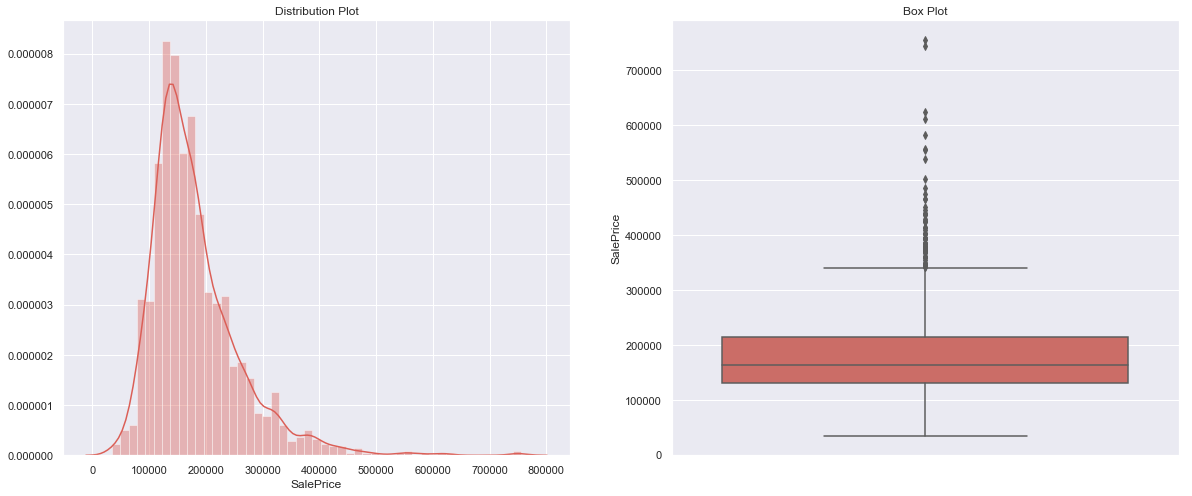

In [480]:
draw_univariate_plot(surprise_housing_df[['SalePrice']])

In [481]:
surprise_housing_df[['SalePrice']].describe()

SalePrice
count    1460.000000
mean   180921.195890
std     79442.502883
min     34900.000000
25%    129975.000000
50%    163000.000000
75%    214000.000000
max    755000.000000

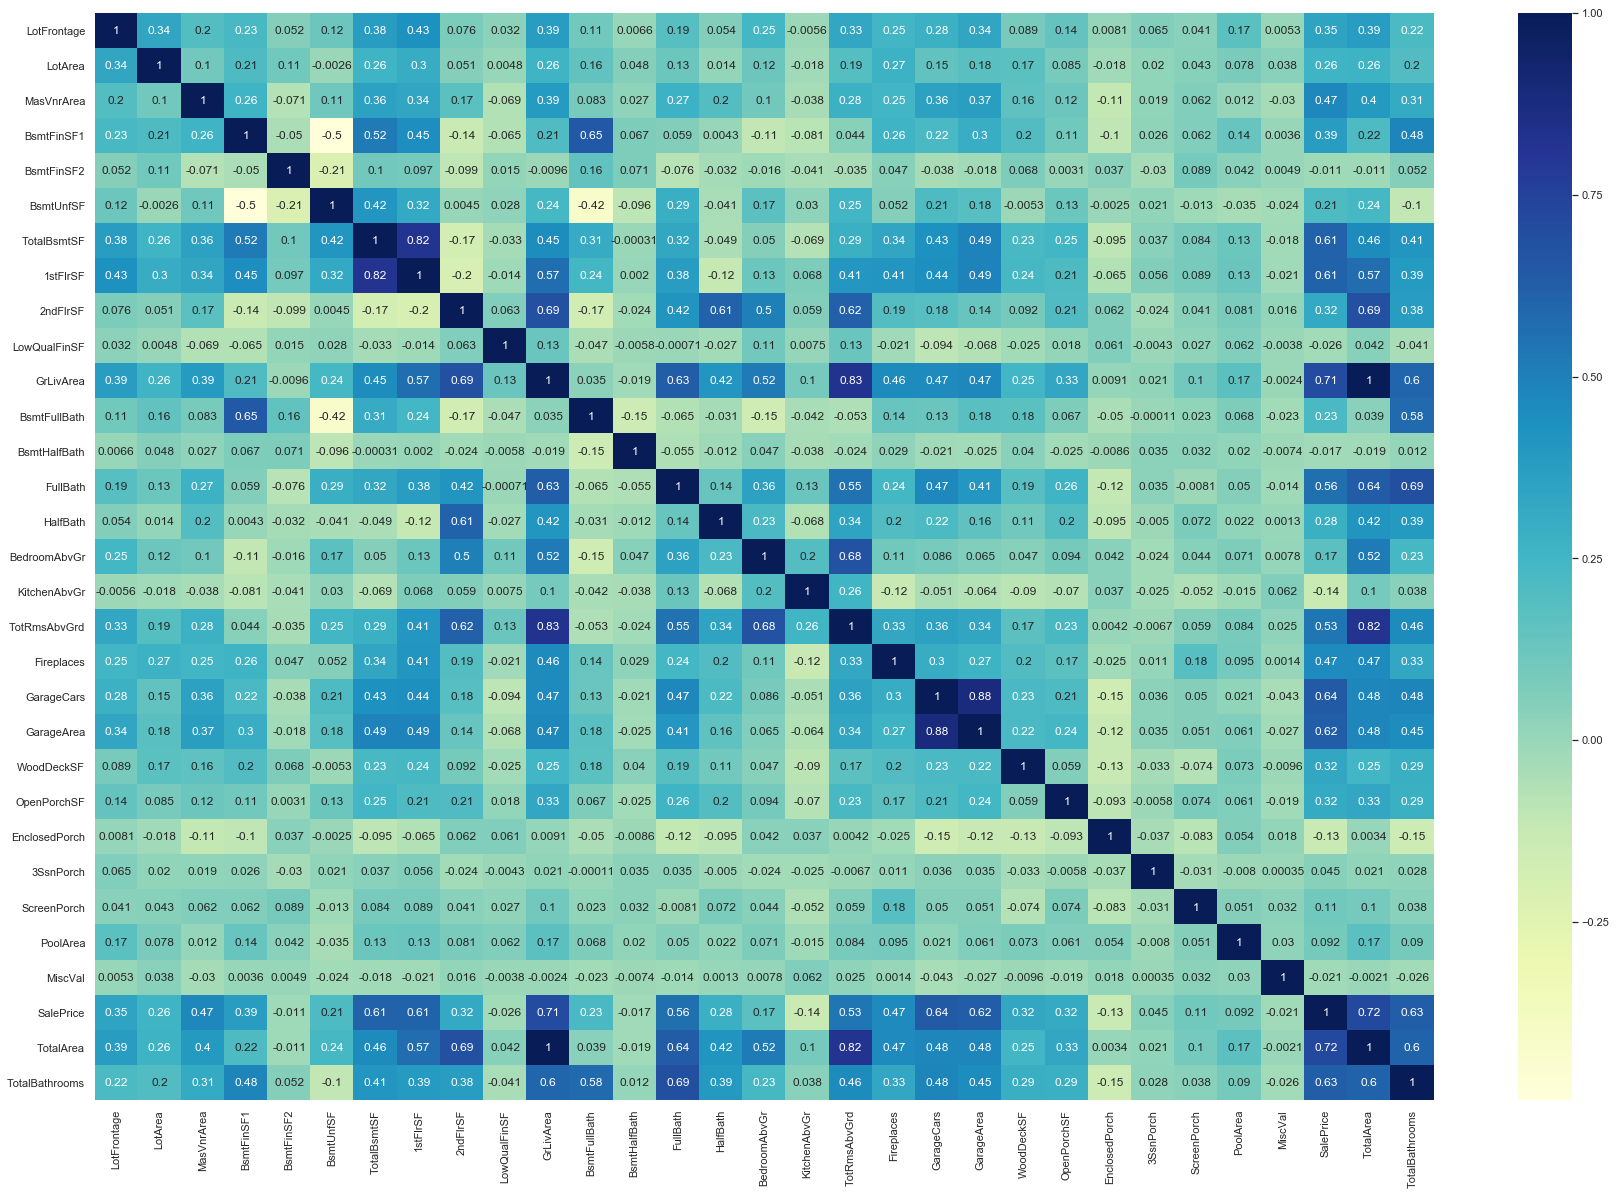

In [482]:
# Find the Correlation of the variable with respect to the dependent variable
# This exercise help us find the Multicollinearlity in the dataframe
plt.figure(figsize = (30,20))
sns.heatmap(surprise_housing_df.corr(), annot=True,cmap="YlGnBu")

#### Other varibles within independent varibles 
- GarageCars is related to GarageArea(88%)
- 1stFlrSF is related to TotalBsmtSF(82%)
- GrLivArea is related to TotRmsAbvGrd(83%)
- GrLivArea is related to TotalArea(87%)
- 1stFlrSF is related to TotalArea(82%)
- TotalBsmtSF is related to TotalArea(83%)

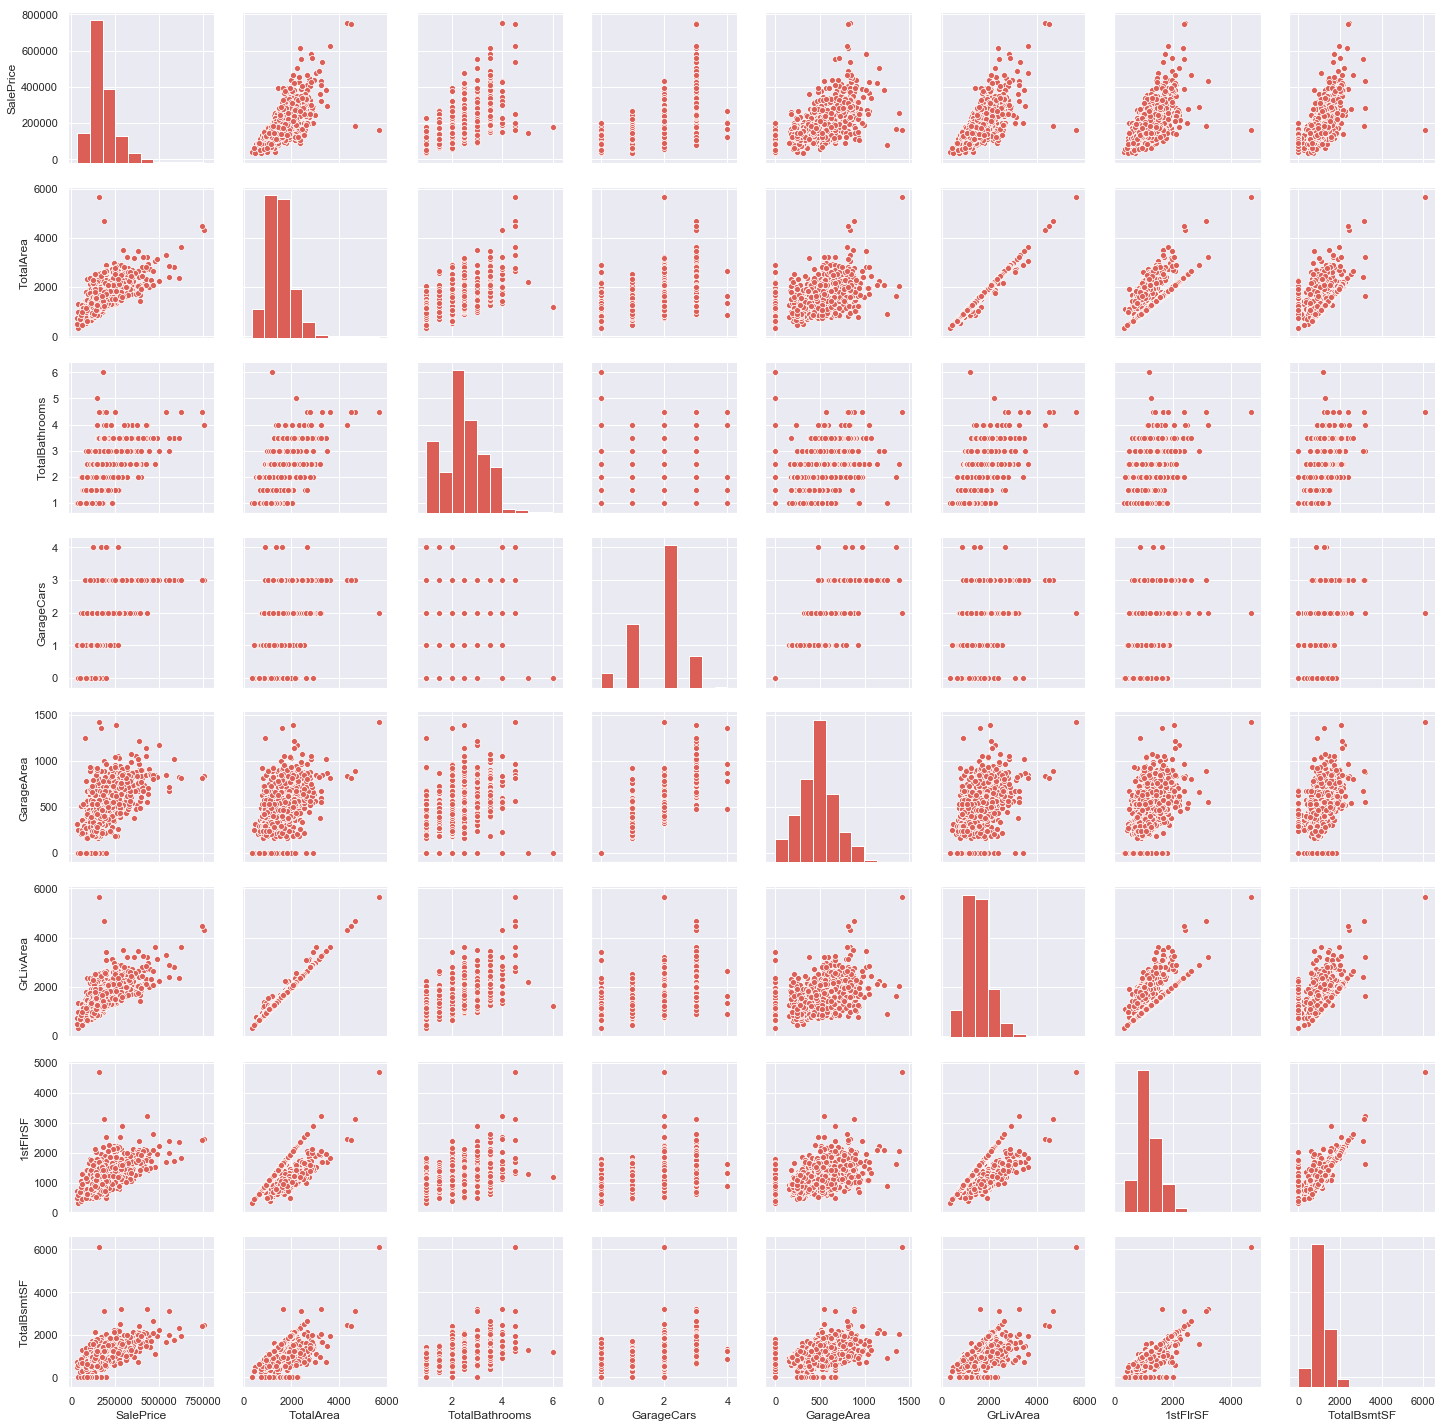

In [483]:
high_corr_list= ['SalePrice', 'TotalArea', 'TotalBathrooms', 'GarageCars', 'GarageArea', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF']

sns.pairplot(surprise_housing_df[high_corr_list])
plt.show()

INFO - Most of the varibles are having linear relaionship with the SalePrice

#### Seems like lots of outlier exists ,lets check each one by one 


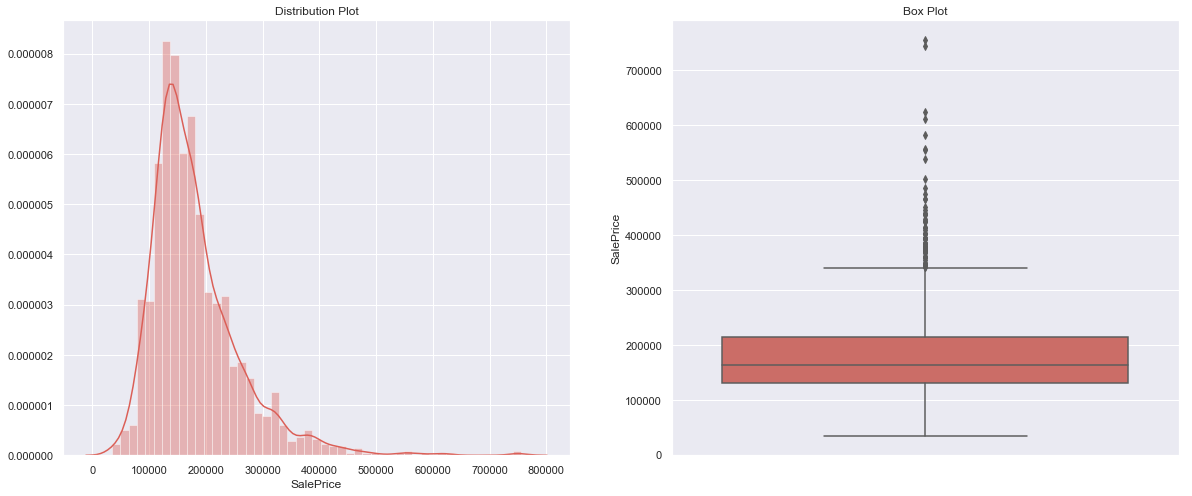

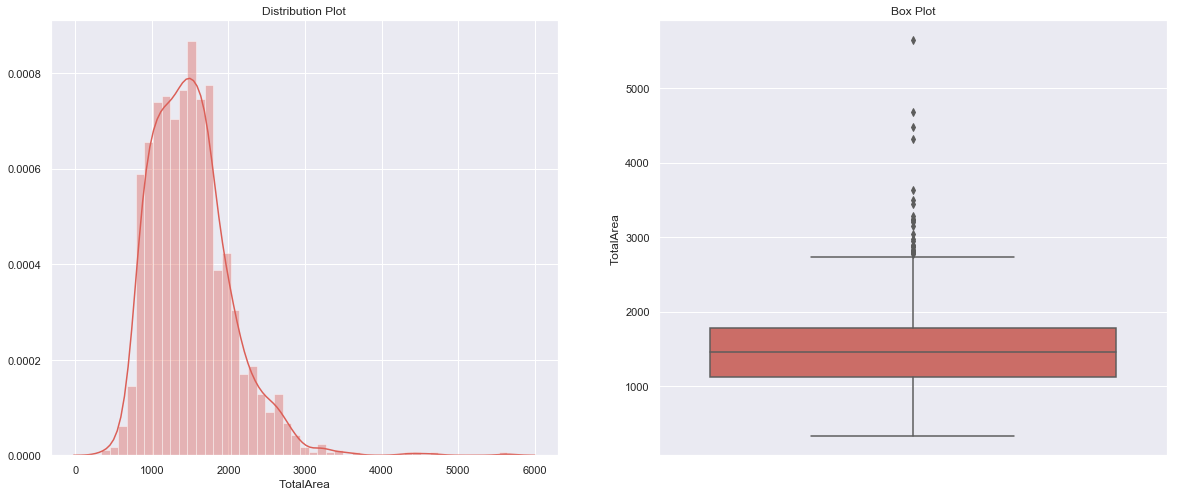

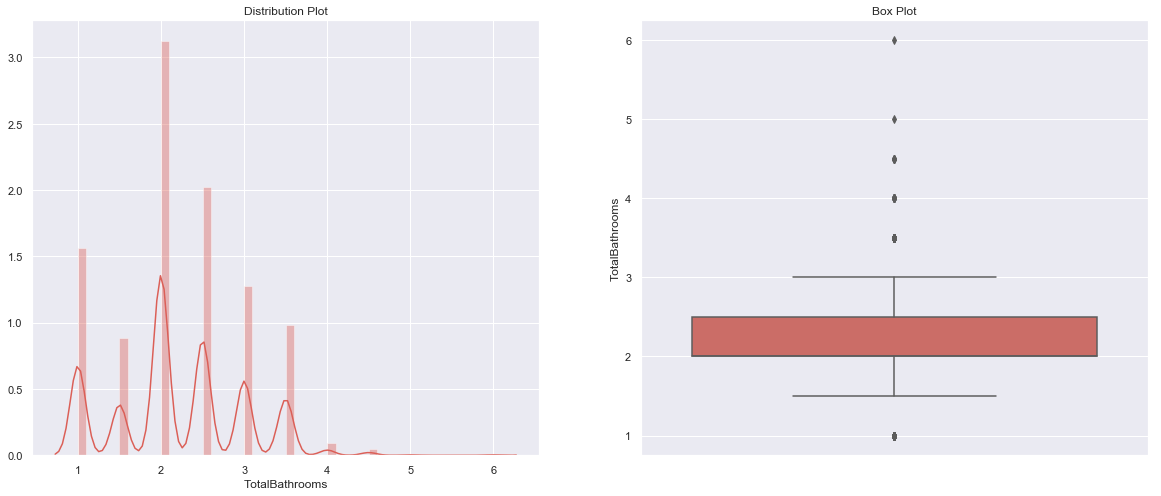

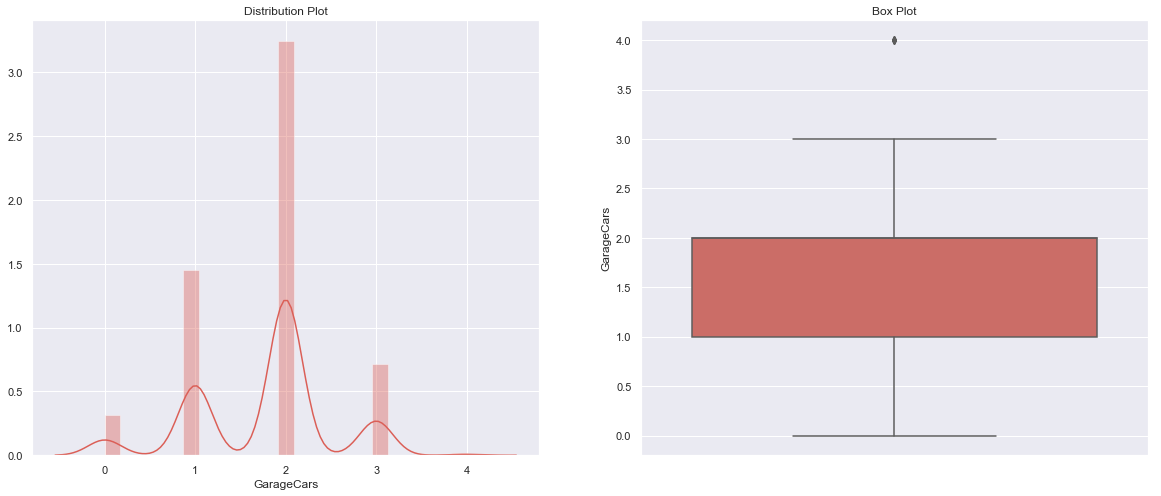

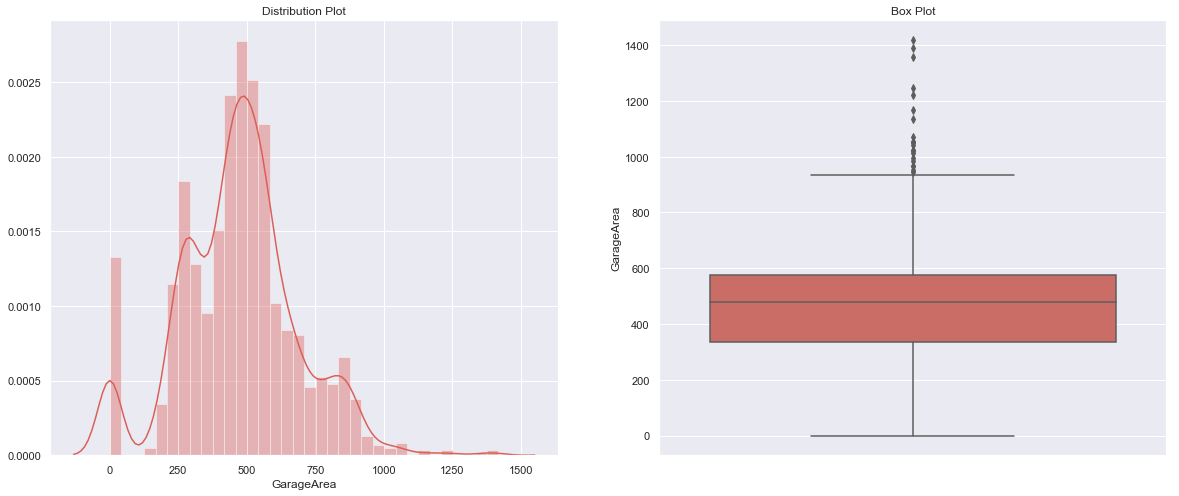

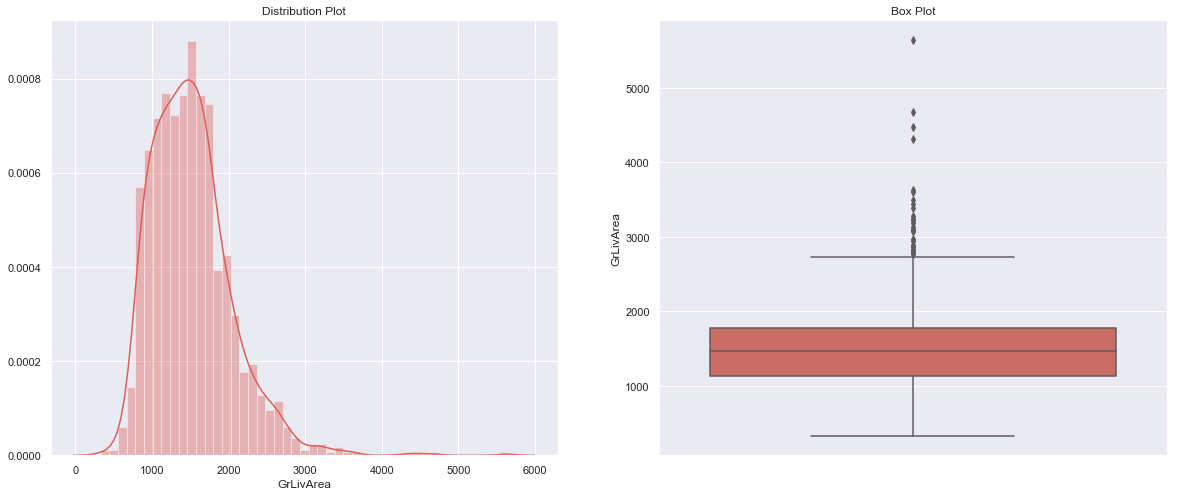

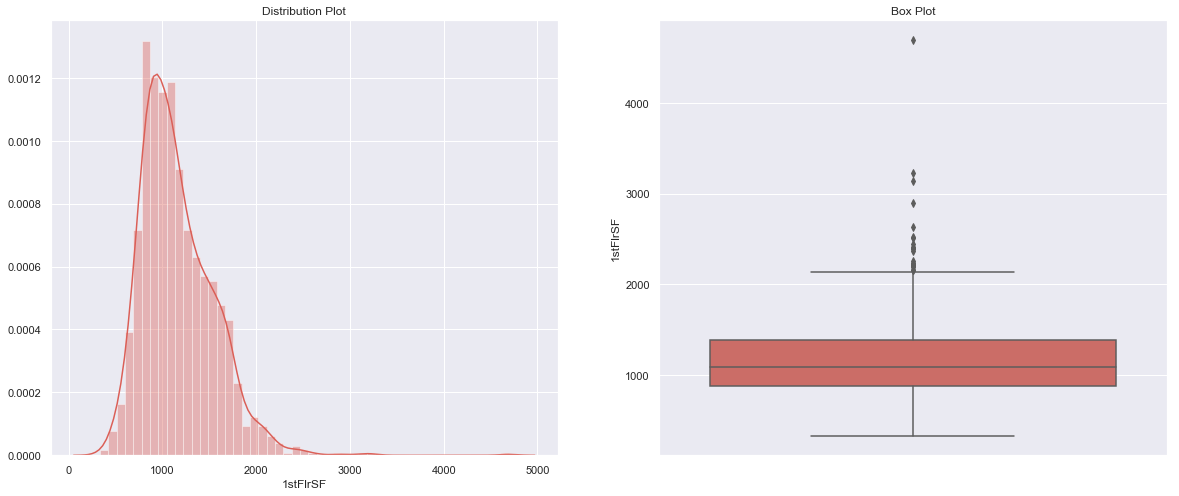

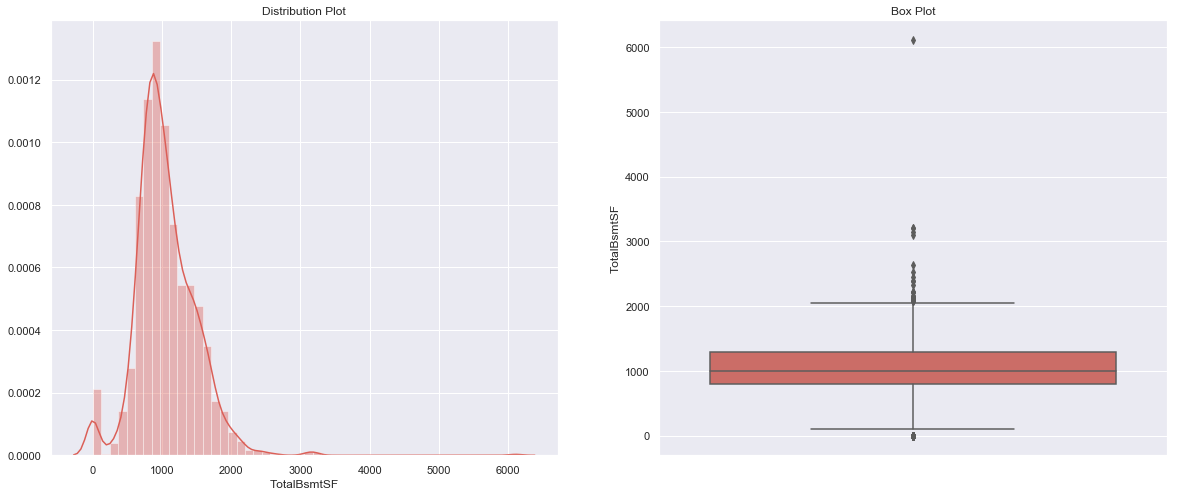

In [484]:
draw_univariate_plot(surprise_housing_df[high_corr_list])

In [485]:
surprise_housing_df[high_corr_list].describe()

SalePrice    TotalArea  TotalBathrooms   GarageCars   GarageArea  \
count    1460.000000  1460.000000     1460.000000  1460.000000  1460.000000   
mean   180921.195890  1511.184247        2.210616     1.767123   472.980137   
std     79442.502883   521.513691        0.785399     0.747315   213.804841   
min     34900.000000   335.000000        1.000000     0.000000     0.000000   
25%    129975.000000  1124.750000        2.000000     1.000000   334.500000   
50%    163000.000000  1459.500000        2.000000     2.000000   480.000000   
75%    214000.000000  1777.250000        2.500000     2.000000   576.000000   
max    755000.000000  5644.000000        6.000000     4.000000  1418.000000   

         GrLivArea     1stFlrSF  TotalBsmtSF  
count  1460.000000  1460.000000  1460.000000  
mean   1515.463699  1162.626712  1057.429452  
std     525.480383   386.587738   438.705324  
min     334.000000   334.000000     0.000000  
25%    1129.500000   882.000000   795.750000  
50%    1464.000000  1087.000000   991.500000  
75%    1776.750000  1391.250000  1298.250000  
max    5642.000000  4692.000000  6110.000000

In [486]:
# Remove outliers
surprise_housing_df = surprise_housing_df[surprise_housing_df['GrLivArea'] < 4000]
surprise_housing_df = surprise_housing_df[surprise_housing_df['TotalBsmtSF'] < 3000]
surprise_housing_df = surprise_housing_df[surprise_housing_df['TotalArea'] < 6000]
surprise_housing_df = surprise_housing_df[surprise_housing_df['GarageArea'] < 1200]
surprise_housing_df = surprise_housing_df[surprise_housing_df['1stFlrSF'] < 3000]

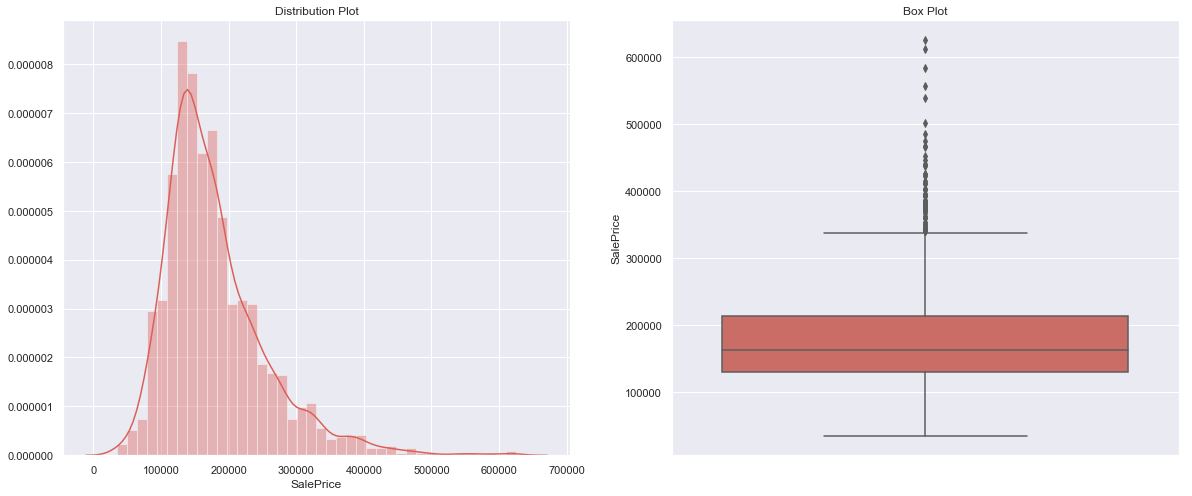

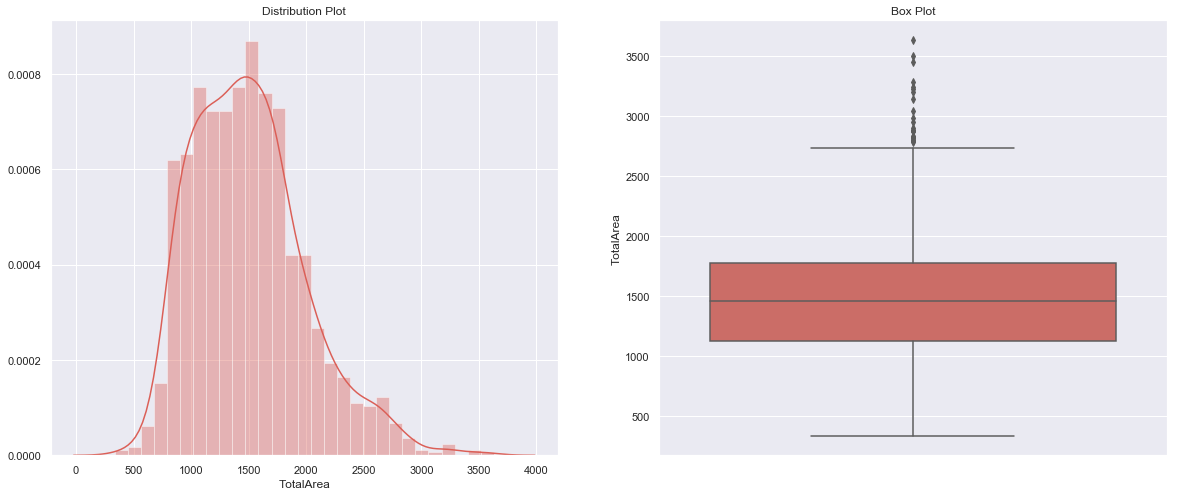

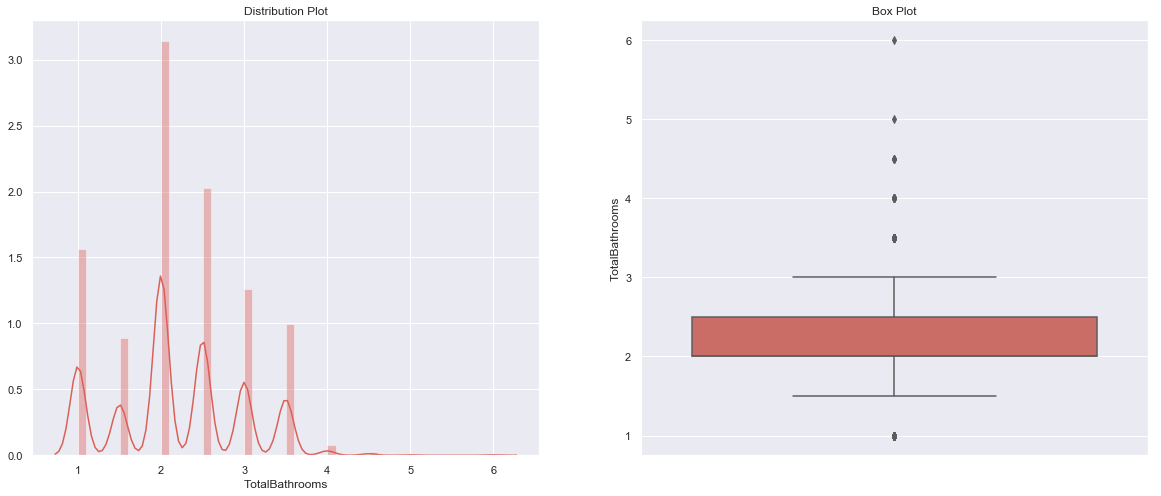

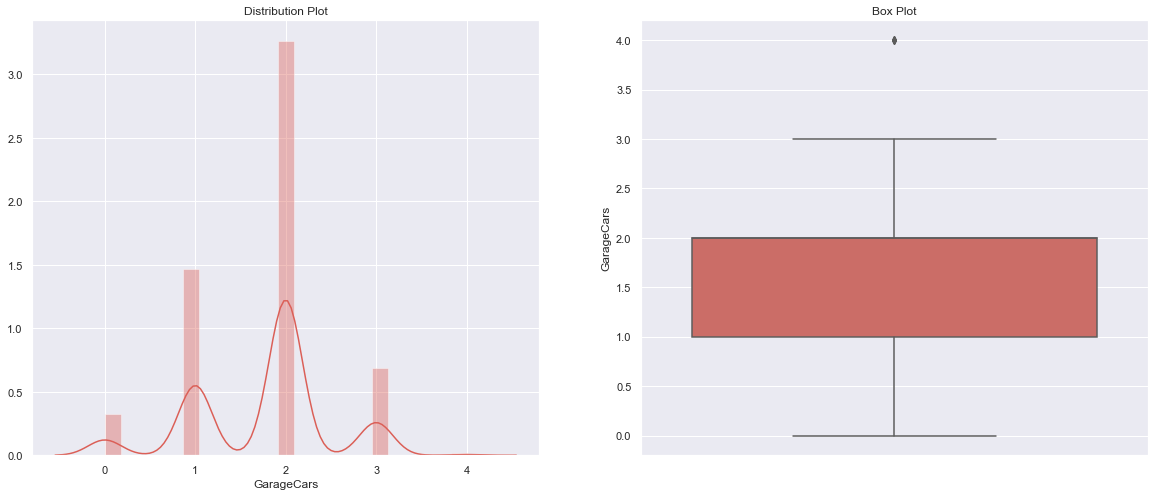

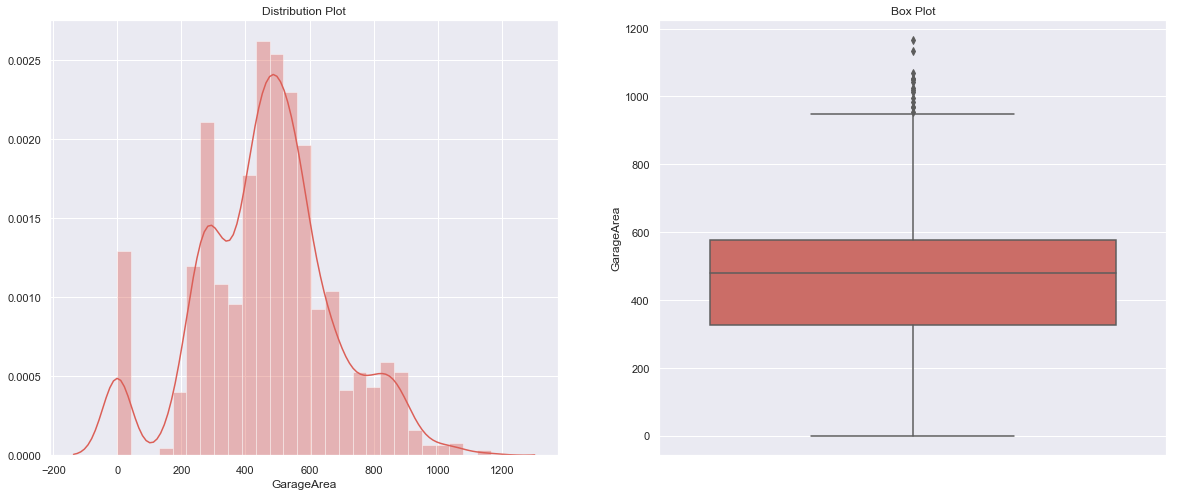

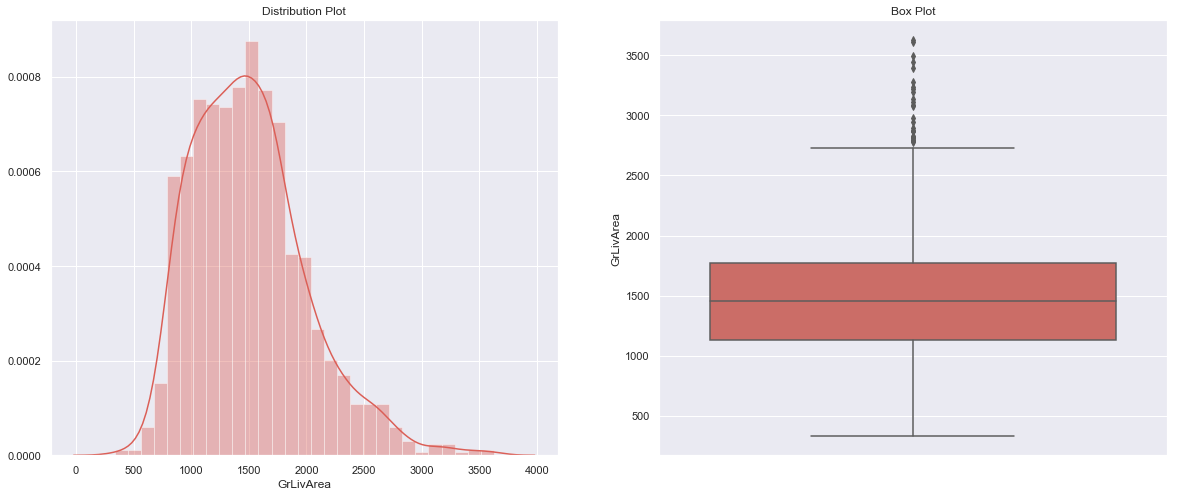

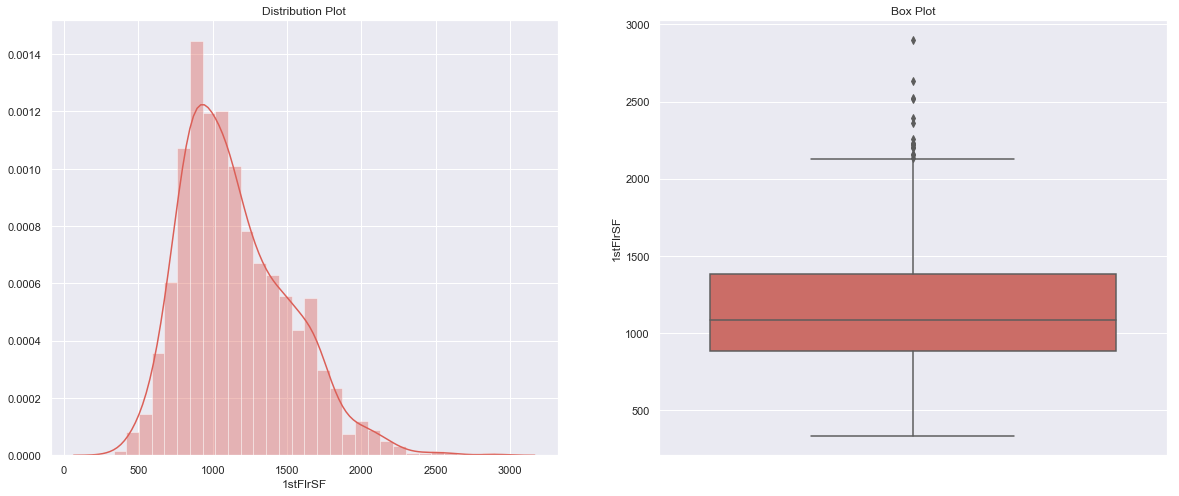

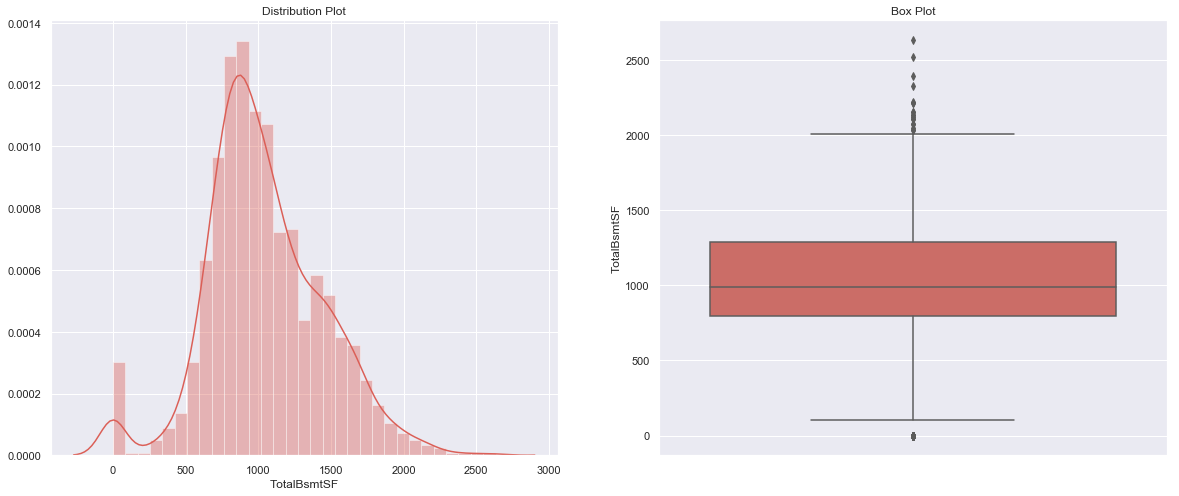

In [487]:
# Again Check for outliers
draw_univariate_plot(surprise_housing_df[high_corr_list])

### Starting with the Model Creation , but before that ,we need to create dummy variables

In [488]:
# Fetch  the numerical variables
var_numeric     = get_variables_type(surprise_housing_df,type_of_var="NUMERIC")
var_numeric

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'SalePrice',
 'TotalArea',
 'TotalBathrooms']

In [489]:
# Remove SalePrice from the list ,as this is independent variable
var_numeric.remove('SalePrice')

In [490]:
# Create dataframe for model evaluation
X_main = surprise_housing_df[var_numeric]
y_main = surprise_housing_df['SalePrice']

In [491]:
# Now we will create dummy varible of the Categorical variables
var_categorical = get_variables_type(surprise_housing_df,type_of_var="CATERGORICAL")

In [492]:
surprise_housing_ctg_df = pd.get_dummies(surprise_housing_df[var_categorical], drop_first = True)

In [493]:
surprise_housing_ctg_df.shape

(1449, 440)

In [494]:
# Concatenate with the categorical dummy variables created
surprise_housing_master = pd.concat([surprise_housing_df, surprise_housing_ctg_df], axis = 1)
surprise_housing_master.shape

(1449, 521)

In [495]:
# Drop original variables as we have created the dummies for them
surprise_housing_master.drop(var_categorical, axis = 1, inplace = True)
print(surprise_housing_master.shape)
surprise_housing_master.head()

(1449, 471)


LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0         65.0     8450       196.0         706           0        150   
1         80.0     9600         0.0         978           0        284   
2         68.0    11250       162.0         486           0        434   
3         60.0     9550         0.0         216           0        540   
4         84.0    14260       350.0         655           0        490   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF          ...            \
0          856       856       854             0          ...             
1         1262      1262         0             0          ...             
2          920       920       866             0          ...             
3          756       961       756             0          ...             
4         1145      1145      1053             0          ...             

   SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0               0             0             0            1   
1               0               0             0             0            1   
2               0               0             0             0            1   
3               0               0             0             0            1   
4               0               0             0             0            1   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 471 columns]

In [496]:
### Split Data into Train and Test Sets
surprise_housing_train, surprise_housing_test = train_test_split(surprise_housing_master, train_size = 0.7, test_size = 0.3, random_state = 100)

In [497]:
### Rescaling the numeric values
scaler = MinMaxScaler()

surprise_housing_train[var_numeric] = scaler.fit_transform(surprise_housing_train[var_numeric])

y_train = surprise_housing_train.pop('SalePrice')
X_train = surprise_housing_train

In [498]:
### Applying the same for the test data 
surprise_housing_test[var_numeric] = scaler.transform(surprise_housing_test[var_numeric])

y_test = surprise_housing_test.pop('SalePrice')
X_test = surprise_housing_test

### Create Model

#### Ridge Regression

In [499]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
ridge_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [500]:
cv_results = pd.DataFrame(ridge_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.021929         0.000907         0.822516          0.972614   
1       0.021524         0.000778         0.824142          0.972613   
2       0.017347         0.000751         0.835092          0.972569   
3       0.017917         0.000787         0.854961          0.972246   
4       0.017286         0.000757         0.865846          0.971795   

  param_alpha             params  rank_test_score  split0_test_score  \
0      0.0001  {'alpha': 0.0001}               26           0.772608   
1       0.001   {'alpha': 0.001}               25           0.774077   
2        0.01    {'alpha': 0.01}               23           0.785267   
3        0.05    {'alpha': 0.05}               22           0.809377   
4         0.1     {'alpha': 0.1}               21           0.823025   

   split0_train_score  split1_test_score       ...         split2_test_score  \
0            0.974592           0.853998       ...                  0.874043   
1            0.974592           0.856603       ...                  0.874400   
2            0.974569           0.871144       ...                  0.877633   
3            0.974324           0.886606       ...                  0.887275   
4            0.973939           0.892470       ...                  0.894001   

   split2_train_score  split3_test_score  split3_train_score  \
0            0.974844           0.846870            0.971571   
1            0.974844           0.847592            0.971571   
2            0.974824           0.853263            0.971549   
3            0.974572           0.867960            0.971301   
4            0.974119           0.877625            0.970886   

   split4_test_score  split4_train_score  std_fit_time  std_score_time  \
0           0.764778            0.973088      0.003735        0.000194   
1           0.767761            0.973087      0.000563        0.000113   
2           0.787919            0.973015      0.000427        0.000030   
3           0.823434            0.972585      0.001267        0.000017   
4           0.841992            0.972068      0.000389        0.000054   

   std_test_score  std_train_score  
0        0.044849         0.002167  
1        0.044292         0.002167  
2        0.040360         0.002185  
3        0.032517         0.002244  
4        0.028440         0.002262  

[5 rows x 21 columns]

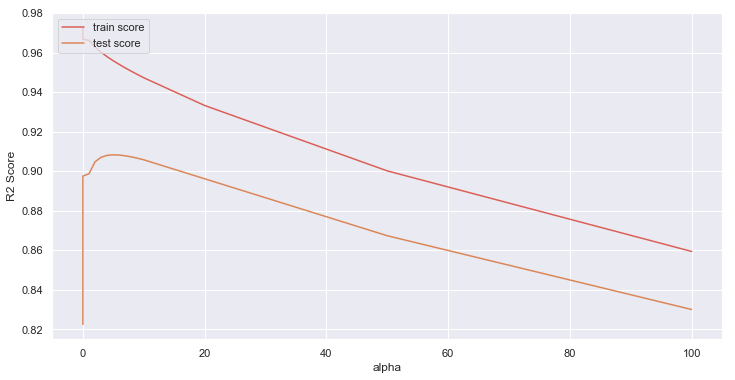

In [501]:
# plotting mean test and train scoes with alpha 
plt.figure(figsize=(12,6))

cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [502]:
ridge_cv.best_score_

0.90839723124058658

In [503]:
ridge_cv.best_params_

{'alpha': 5.0}

In [504]:
alpha = 5

ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [505]:
# predict
y_train_pred = ridge.predict(X_train)
print(r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = ridge.predict(X_test)
print(r2_score(y_true=y_test, y_pred=y_test_pred))

0.953717537913
0.882785775272


#### Lasso Regression

In [506]:
lasso = Lasso()

# cross validation
lasso_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   34.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [507]:
cv_results = pd.DataFrame(lasso_cv.cv_results_)
cv_results.head()

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       0.319125         0.000743         0.828664          0.972582   
1       0.310927         0.000849         0.828545          0.972582   
2       0.300702         0.000792         0.828705          0.972582   
3       0.289526         0.000836         0.828193          0.972580   
4       0.291912         0.000789         0.829428          0.972578   

  param_alpha             params  rank_test_score  split0_test_score  \
0      0.0001  {'alpha': 0.0001}               26           0.775813   
1       0.001   {'alpha': 0.001}               27           0.775878   
2        0.01    {'alpha': 0.01}               25           0.776521   
3        0.05    {'alpha': 0.05}               28           0.778793   
4         0.1     {'alpha': 0.1}               24           0.781306   

   split0_train_score  split1_test_score       ...         split2_test_score  \
0            0.974590           0.859729       ...                  0.865876   
1            0.974590           0.859618       ...                  0.866155   
2            0.974590           0.859321       ...                  0.868737   
3            0.974590           0.861438       ...                  0.872275   
4            0.974588           0.862898       ...                  0.873991   

   split2_train_score  split3_test_score  split3_train_score  \
0            0.974839           0.841263            0.971555   
1            0.974839           0.841380            0.971555   
2            0.974839           0.841884            0.971555   
3            0.974838           0.841157            0.971554   
4            0.974837           0.841762            0.971553   

   split4_test_score  split4_train_score  std_fit_time  std_score_time  \
0           0.800502            0.973007      0.044976        0.000034   
1           0.799549            0.973007      0.044643        0.000060   
2           0.796902            0.973006      0.037246        0.000007   
3           0.787100            0.973002      0.043466        0.000084   
4           0.786974            0.972997      0.039464        0.000013   

   std_test_score  std_train_score  
0        0.034920         0.002181  
1        0.035104         0.002181  
2        0.035915         0.002181  
3        0.038326         0.002181  
4        0.038405         0.002182  

[5 rows x 21 columns]

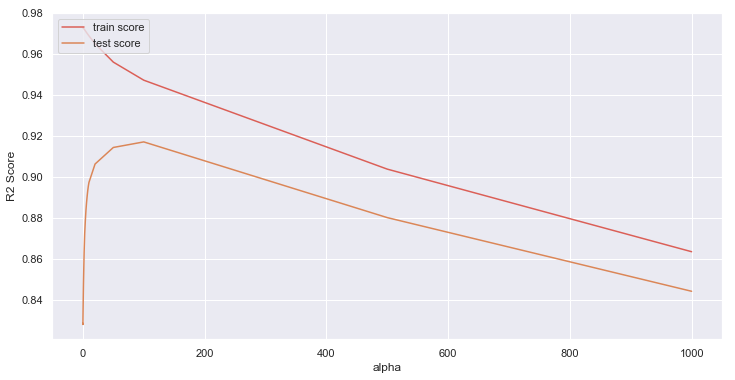

In [508]:
# plotting mean test and train scoes with alpha 
plt.figure(figsize=(12,6))

cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [509]:
lasso_cv.best_score_

0.91710063262273533

In [510]:
lasso_cv.best_params_

{'alpha': 100}

Optimal value of lambda for lasso is 100.

In [511]:
alpha =100
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train) 

Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [512]:
# predict
y_train_pred = lasso.predict(X_train)
print(r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lasso.predict(X_test)
print(r2_score(y_true=y_test, y_pred=y_test_pred))

0.943944104859
0.890748926096


In [513]:
coef = pd.Series(lasso.coef_, index = X_train.columns)
var_selected = sum(coef != 0)
print('Lasso has  {} variables'.format(var_selected))

Lasso has  126 variables


In [514]:
# Best variables predicting housing prices as per Lasso Regression
main_coef = pd.concat([coef.sort_values().head(10),
                       coef.sort_values().tail(10)])

main_coef.sort_values(ascending=False)

TotalArea               86776.448884
GrLivArea               65023.488332
OverallQual_10          63215.098648
OverallQual_9           54874.731096
TotalBsmtSF             54042.795018
LotArea                 44214.567567
RoofMatl_WdShngl        34021.516900
Neighborhood_StoneBr    33092.467577
SaleType_New            32413.942688
OverallQual_8           25524.170187
ExterQual_TA            -6408.773356
BsmtQual_Fa             -9436.170817
OverallCond_4          -10699.425319
BsmtQual_Gd            -11946.576176
BsmtQual_TA            -13391.217093
KitchenQual_Gd         -13733.264617
KitchenQual_TA         -14823.646358
KitchenQual_Fa         -15332.674252
OverallCond_3          -20276.701779
KitchenAbvGr           -25695.958379
dtype: float64

Text(0.5,1,'Coefficients in the Lasso Model')

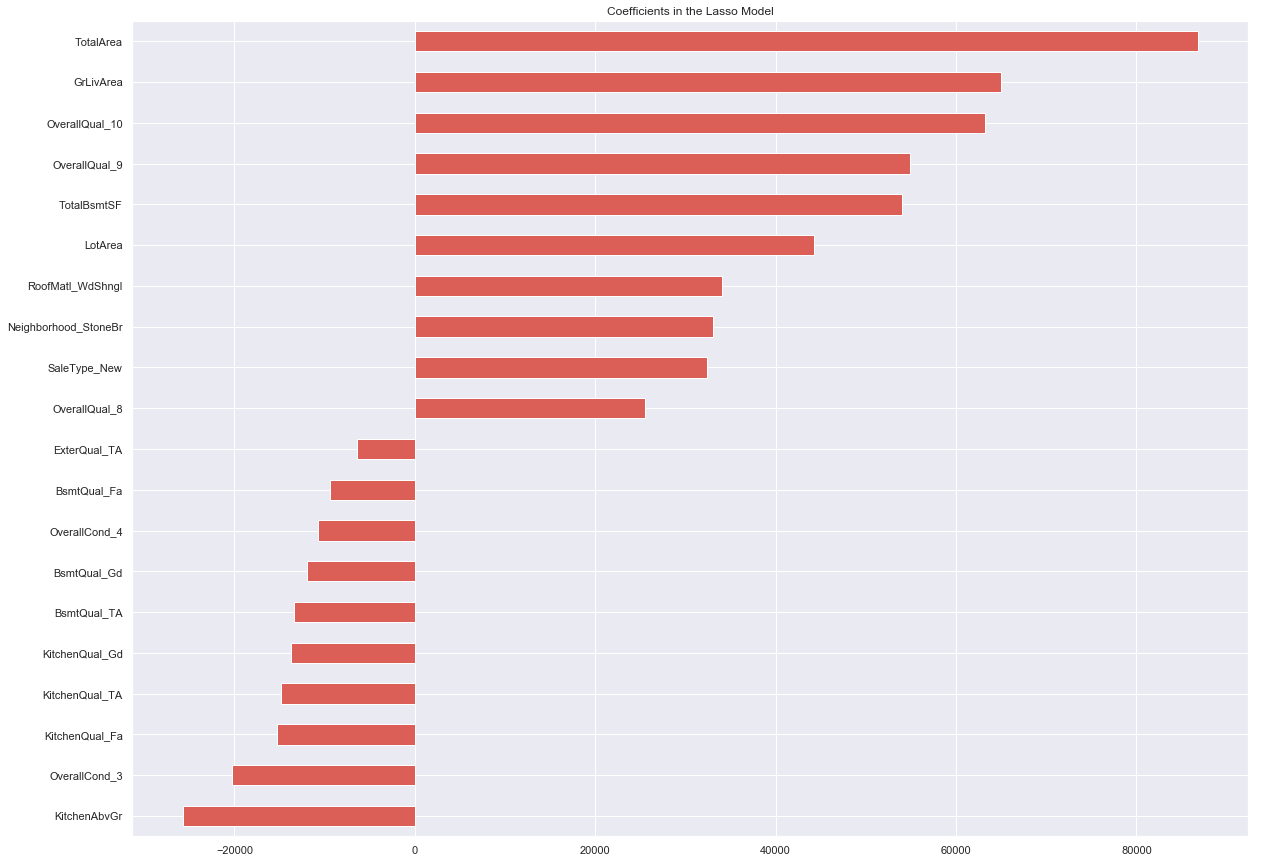

In [515]:
# Let's plot these variables
plt.figure(figsize = (20,15))

main_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Conclusion:

Following are the most significant variables in predicting the price of a house:

- Total Square Feet (TotalArea)
    - TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
- GrLivArea
- Overall material and finish of the house (OverallQual):
    - 10 Very Excellent
    - 9	Excellent
    - 8	Very Good
- LotArea
- Roof material (RoofMatl)
    - Wood Shingles
- Neighborhood
    - Stone Brook
- Type of sale (SaleType)
    - Home just constructed and sold
- GarageCars